In [1]:
import skimage
from skimage import data,color,io, img_as_ubyte, measure, filters
from skimage.feature import canny
from skimage.transform import hough_ellipse, hough_circle, hough_circle_peaks, rescale,resize
from skimage.draw import ellipse_perimeter
from skimage import io, transform, feature, morphology
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, skeletonize
from skimage.draw import circle_perimeter
from skimage.color import rgb2gray 
from scipy import ndimage as ndi
from skimage.filters import sobel

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange, tqdm

import PIL
from PIL import Image, ImageDraw
from scipy import signal, ndimage
from math import sqrt, pi, cos, sin
from collections import defaultdict

from scipy import ndimage

In [2]:
moon = io.imread('big_moon.tif')
#moon = (rgb2gray(moonin)*255).astype(dtype=np.uint8)

Text(0.5, 1.0, 'Original Moon')

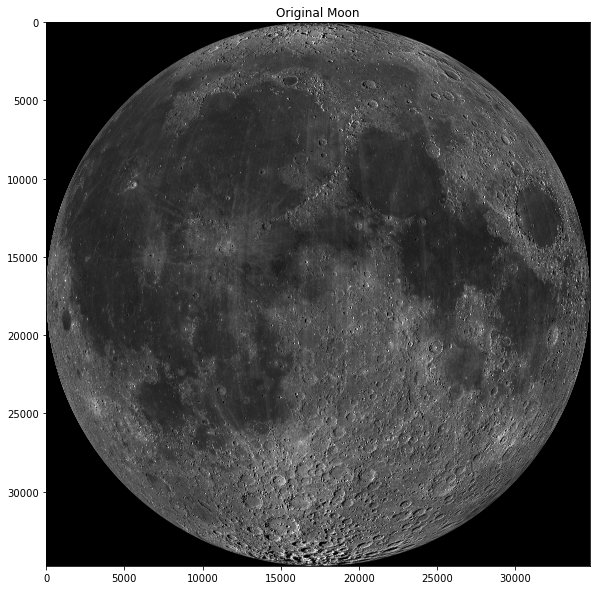

In [63]:
plt.figure(figsize=(20,10))
plt.imshow(moon,cmap='gray')
plt.title('Original Moon')

Text(0.5, 1.0, 'CRATER 1')

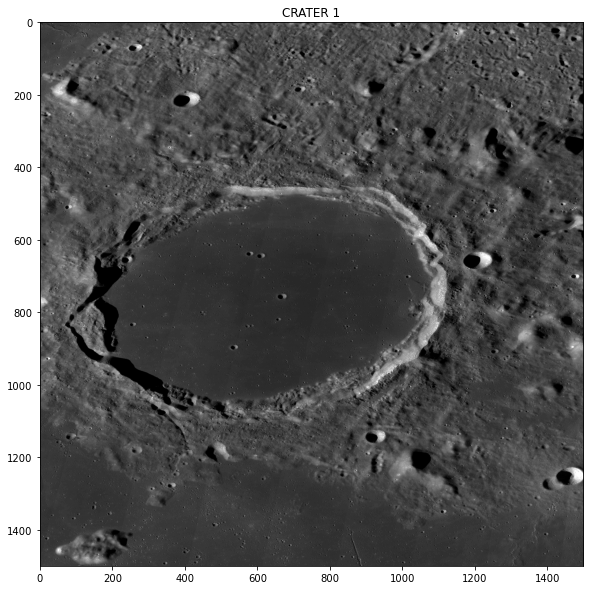

In [26]:
#vyrez z povodneho mesiaca Crater_1
crater_1 = rgb2gray(moon[3000:4500,15000:16500])
plt.figure(figsize=(20,10))
plt.imshow(crater_1,cmap='gray')
plt.title('CRATER 1')

In [27]:
io.imsave('crater_1.png',crater_1)

Text(0.5, 1.0, ' RESIZE CRATER 1')

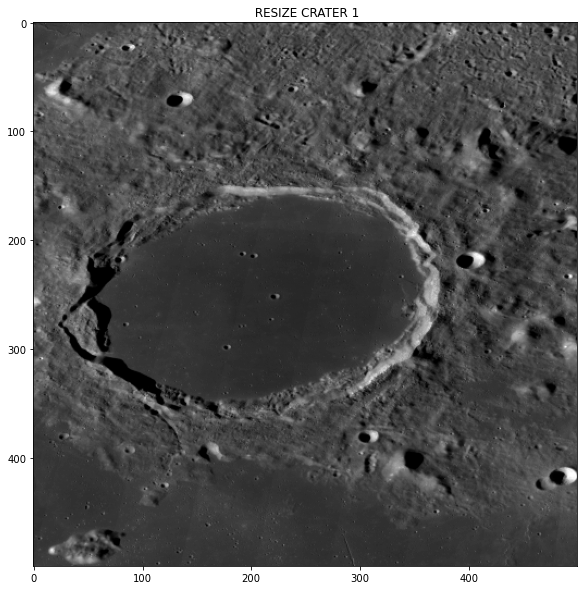

In [28]:
crater_resize = transform.resize(crater_1,(int(1500/3), int(1500/3)))
plt.figure(figsize=(20,10))
plt.imshow(crater_resize,cmap='gray')
plt.title(' RESIZE CRATER 1')

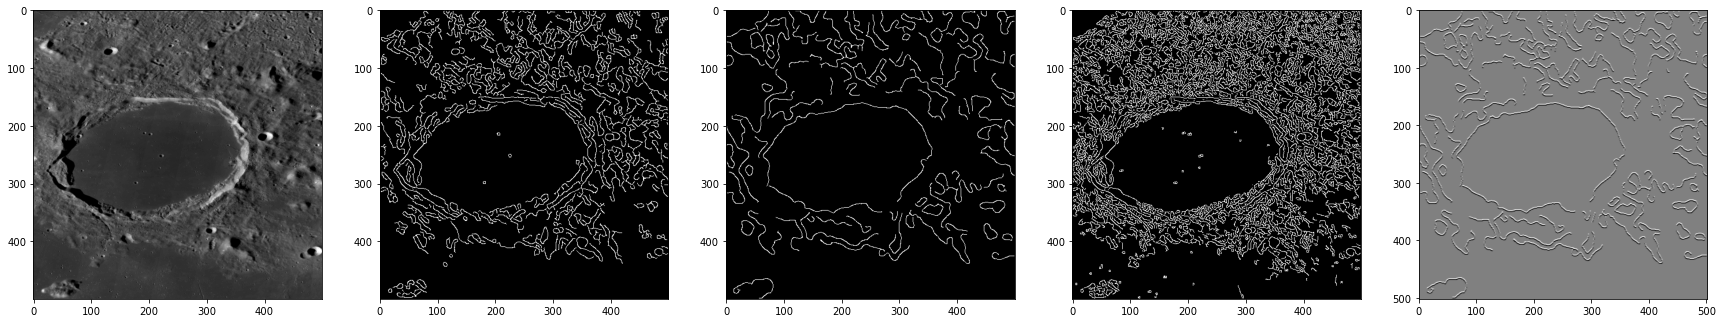

In [29]:
sobel_mask = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

edges = feature.canny(img_as_ubyte(crater_resize), sigma= 2, high_threshold= 50, low_threshold=10)
edges1 = canny(edges,sigma=3.8)
edges2 = canny(crater_resize)
edges3 = signal.convolve2d(edges1,sobel_mask)
plt.figure(figsize=(30,10))
plt.subplot(151)
plt.imshow(crater_resize,cmap='gray')
plt.subplot(152)
plt.imshow(edges,cmap='gray')
plt.subplot(153)
plt.imshow(edges1,cmap='gray')
plt.subplot(154)
plt.imshow(edges2,cmap='gray')
plt.subplot(155)
plt.imshow(edges3,cmap='gray')

In [30]:
input_image = Image.open("crater_resize.png")

#Define for output crater
output_crater = Image.new("RGB", input_image.size)
output_crater.paste(input_image)
draw_result = ImageDraw.Draw(output_crater)

#Parametres for my crater
rmin = 156
rmax = 162
steps = 4
threshold = 0.8

#Search point with my parametres
points = []
for r in range(rmin, rmax):
    for t in range(steps):
        points.append((r, int(r * cos(2 * pi * t / steps)), int(r * sin(2 * pi * t / steps))))

acc = defaultdict(int)
for x in range(edges3.shape[0]):
    for y in range(edges3.shape[1]):
        if edges3[x][y]:
            for r, dx, dy in points:
                a = x - dx
                b = y - dy
                acc[(a, b, r)] += 1

circles = []
for k, v in sorted(acc.items(), key=lambda i: -i[1]):
    x, y, r = k
    if v / steps >= threshold and all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc in circles):
        print(v / steps, x, y, r)
        circles.append((x, y, r))

for x, y, r in circles:
    draw_result.ellipse((x-r, y-r, x+r, y+r), outline=(255,0,0,0))


1.0 182 247 161


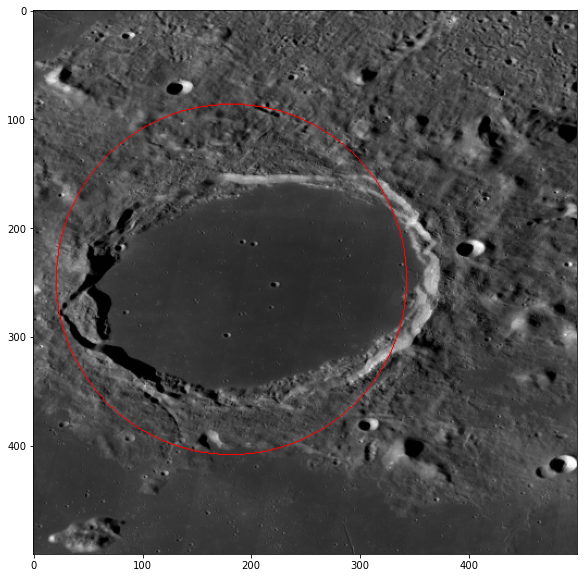

In [31]:
plt.figure(figsize=(15,10))
plt.imshow(output_crater,cmap='gray')

In [32]:
io.imsave("target_crater.jpg",output_crater)

AttributeError: 'Image' object has no attribute 'dtype'

In [33]:
loc_x1 = x-r
loc_x2 = r+x
loc_y1 = y-r
loc_y2 = r+y
print(loc_x1,loc_x2,loc_y1,loc_y2)


21 343 86 408


Text(0.5, 1.0, ' INSIDE CRATER')

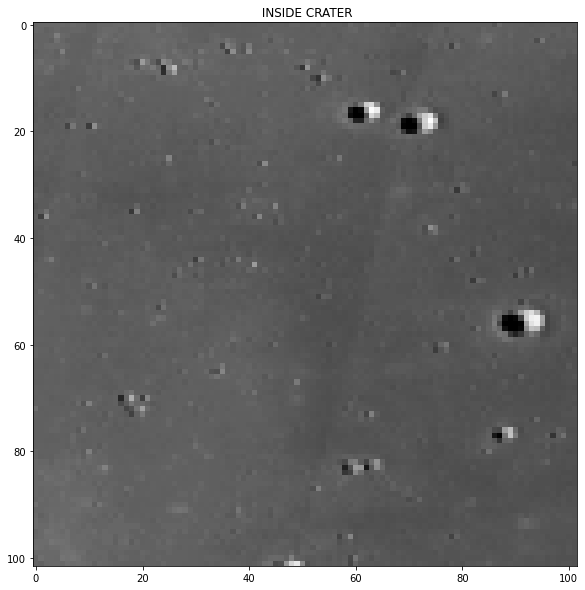

In [34]:
inside_crater = crater_resize[loc_y1+110:loc_y2-110,loc_x1+110:loc_x2-110]
plt.figure(figsize=(20,10))
plt.imshow(inside_crater,cmap='gray')
plt.title(' INSIDE CRATER')


In [35]:
io.imsave('inside_crater.png',inside_crater)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Text(0.5, 1.0, 'FILL')

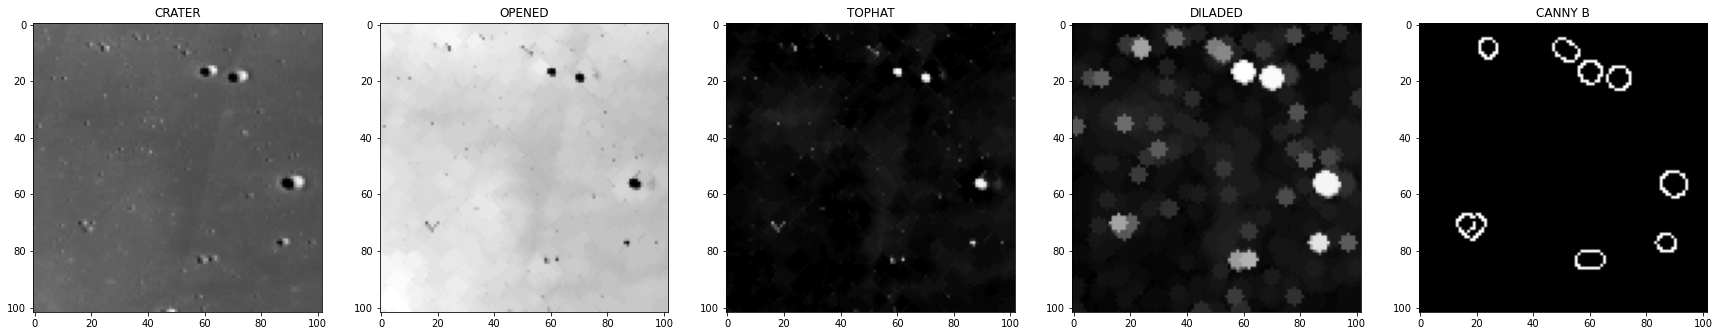

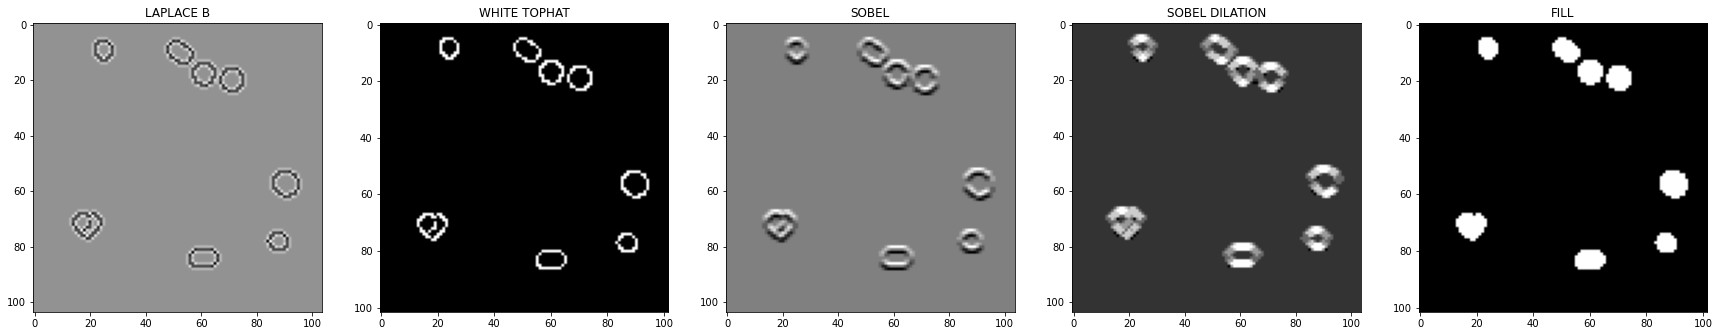

In [36]:
laplace_1_mask = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
laplace_2_mask = np.ones((3,3))
laplace_2_mask[1,1] = -8
sobel_mask = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])



opened = opening(inside_crater, morphology.disk(2))
tophat = morphology.black_tophat(opened, morphology.disk(20))
diladed = dilation(tophat, morphology.disk(3))
canny_b = canny(diladed, sigma=1)
laplace_1_b = signal.convolve2d(canny_b,laplace_1_mask)
w_tophat = white_tophat(canny_b, morphology.disk(100))
sobel = signal.convolve2d(w_tophat,sobel_mask)
sobel_dilation = dilation(sobel, morphology.disk(1))
fill = ndi.binary_fill_holes(w_tophat)

plt.figure(figsize=(30,10))
plt.subplot(151)
plt.imshow(inside_crater,cmap='gray')
plt.title('CRATER')
plt.subplot(152)
plt.imshow(opened,cmap='gray')
plt.title('OPENED')
plt.subplot(153)
plt.imshow(tophat,cmap='gray')
plt.title('TOPHAT')
plt.subplot(154)
plt.imshow(diladed,cmap='gray')
plt.title('DILADED')
plt.subplot(155)
plt.imshow(canny_b,cmap='gray')
plt.title('CANNY B')

plt.figure(figsize=(30,10))
plt.subplot(151)
plt.imshow(laplace_1_b,cmap='gray')
plt.title('LAPLACE B')
plt.subplot(152)
plt.imshow(w_tophat,cmap='gray')
plt.title('WHITE TOPHAT')
plt.subplot(153)
plt.imshow(sobel,cmap='gray')
plt.title('SOBEL')
plt.subplot(154)
plt.imshow(sobel_dilation,cmap='gray')
plt.title('SOBEL DILATION')
plt.subplot(155)
plt.imshow(fill,cmap='gray')
plt.title('FILL')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


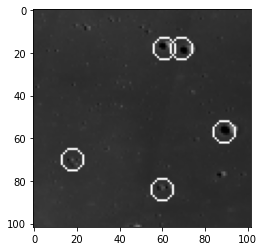

In [72]:
# Detect two radii
hough_radii = np.arange(5,21,100)
hough_res = hough_circle(canny_b, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=5)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(inside_crater)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

In [37]:
input_image = Image.open("inside_crater.png")

# Output image:
output_image = Image.new("RGB", input_image.size)
output_image.paste(input_image)
draw_result = ImageDraw.Draw(output_image)

# Find circles
rmin = 6
rmax = 8
steps = 100
threshold = 0.4

points = []
for r in range(rmin, rmax):
    for t in range(steps):
        points.append((r, int(r * cos(2 * pi * t / steps)), int(r * sin(2 * pi * t / steps))))

acc = defaultdict(int)
for x in range(canny_b.shape[0]):
    for y in range(canny_b.shape[1]):
        if canny_b[x][y]:   
            for r, dx, dy in points:
                a = x - dx
                b = y - dy
                acc[(a, b, r)] += 1

circles = []
for k, v in sorted(acc.items(), key=lambda i: -i[1]):
    x, y, r = k
    if v / steps >= threshold and all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc in circles):
        print(v / steps, x, y, r)
        circles.append((x, y, r))
        if circles == 5:
            break

for x, y, r in circles:
    draw_result.ellipse((y-r, x-r, y+r, x+r), outline=(60,179,113,20))


0.43 18 69 6
0.41 18 61 6
0.41 57 89 6
0.41 72 18 6
0.4 85 60 6


Text(0.5, 1.0, '5 CRATERS INSIDE BIG CRATER')

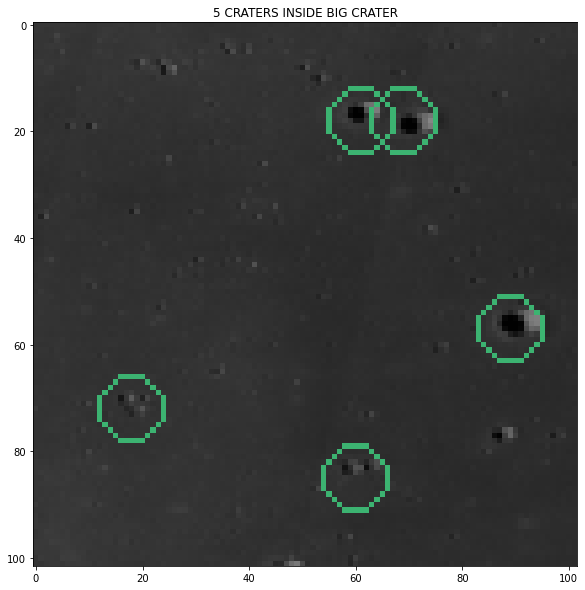

In [38]:
plt.figure(figsize=(15,10))
plt.imshow(output_image,cmap='gray')
plt.title("5 CRATERS INSIDE BIG CRATER")

In [39]:
input_image = Image.open("target_crater.jpg")

# Output image:
output_image = Image.new("RGB", input_image.size)
output_image.paste(input_image)
draw_result = ImageDraw.Draw(output_image)

# Find circles
rmin = 6
rmax = 8
steps = 100
threshold = 0.4

points = []
for r in range(rmin, rmax):
    for t in range(steps):
        points.append((r, int(r * cos(2 * pi * t / steps)), int(r * sin(2 * pi * t / steps))))

acc = defaultdict(int)
for x in range(canny_b.shape[0]):
    for y in range(canny_b.shape[1]):
        if canny_b[x][y]:   
            for r, dx, dy in points:
                a = x - dx
                b = y - dy
                acc[(a+196, b+131, r)] += 1

circles = []
for k, v in sorted(acc.items(), key=lambda i: -i[1]):
    x, y, r = k
    if v / steps >= threshold and all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc in circles):
        print(v / steps, x, y, r)
        circles.append((x, y, r))
        if circles == 5:
            break

for x, y, r in circles:
    draw_result.ellipse((y-r, x-r, y+r, x+r), outline=(60,179,113,20))

0.43 214 200 6
0.41 214 192 6
0.41 253 220 6
0.41 268 149 6
0.4 281 191 6


Text(0.5, 1.0, 'ALL CRATERS IN ONE')

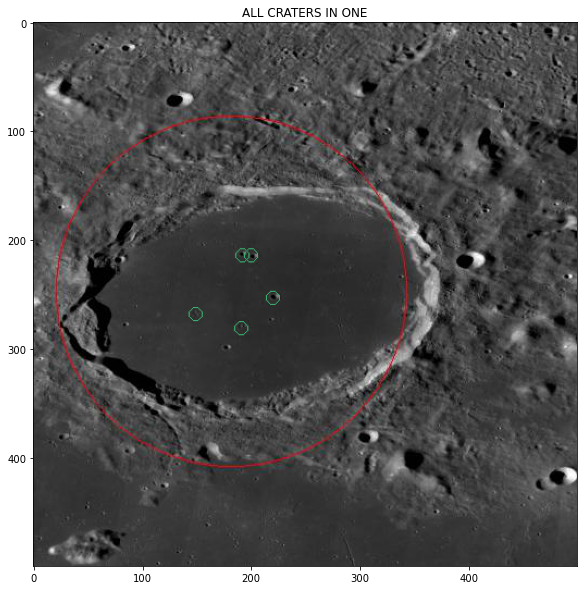

In [41]:
plt.figure(figsize=(15,10))
plt.imshow(output_image,cmap='gray')
plt.title("ALL CRATERS IN ONE")